<a href="https://colab.research.google.com/github/gnitnaw/Programs/blob/master/Chapter9/ImageClassificationPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.7.13


# Section 9.5.2
## Import modules

In [2]:
!rm fashionmnist.zip
!rm fashion-mnist_test.csv
!rm fashion-mnist_train.csv
!rm t10k-images-idx3-ubyte
!rm t10k-labels-idx1-ubyte
!rm train-labels-idx1-ubyte
!rm train-images-idx3-ubyte

!wget https://raw.github.com/gnitnaw/Programs/master/Chapter9/fashionmnist.zip
!unzip fashionmnist.zip

import torch 
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn.functional as F
print(np.__version__)


--2022-04-13 11:10:47--  https://raw.github.com/gnitnaw/Programs/master/Chapter9/fashionmnist.zip
Resolving raw.github.com (raw.github.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.github.com (raw.github.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/gnitnaw/Programs/master/Chapter9/fashionmnist.zip [following]
--2022-04-13 11:10:47--  https://raw.githubusercontent.com/gnitnaw/Programs/master/Chapter9/fashionmnist.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72114606 (69M) [application/zip]
Saving to: ‘fashionmnist.zip’

fashionmnist.zip    100%[===================>]  68.77M   208MB/s    in 0.3s    

2022-04-13 11:10:47

## Set random seed

In [3]:
np.random.seed(1234)

## Original Program

In [4]:
#################################################################
# data loader class
#################################################################
class LoadData(Dataset):
    def __init__(self, fName, transform=None):
        data = pd.read_csv(fName)
        self.X = np.array(data.iloc[:, 1:], dtype=np.uint8).reshape(-1, 1, 28, 28)
        self.y = np.array(data.iloc[:, 0])
                
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = self.X[idx]
        lbl = self.y[idx]    
        return (img, lbl)

# load the image data 
train_ds = LoadData('fashion-mnist_train.csv')
test_ds  = LoadData('fashion-mnist_test.csv')

# set labels dictionary
labels = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 
          3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
          7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

im = Image.fromarray(train_ds[1][0].reshape(28,28))
im.save("im1.pdf")
im = Image.fromarray(train_ds[4][0].reshape(28,28))
im.save("im2.pdf")

# load the data in batches
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                          batch_size=batch_size,
                                          shuffle=True)     

# define the network
class CNN(nn.Module):
    
   def __init__(self):
        super(CNN, self).__init__()
                
        self.cnn_layer = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=(1,1)),
                nn.ReLU(),
                nn.Conv2d(16, 32, kernel_size=3, stride=(1,1)),
                nn.ReLU(),
        )
        self.flat_fts = (((28-3+1)-3+1)**2)*32
    
        
        self.flat_layer = nn.Sequential(
                nn.Linear(self.flat_fts, 100),
                nn.ReLU(),
                nn.Linear(100, 100),
                nn.ReLU(),
                nn.Linear(100, 100),
                nn.ReLU(),
                nn.Linear(100, 10))
         
   def forward(self, x):
        out = self.cnn_layer(x)
        out = out.view(-1, self.flat_fts)
        out = self.flat_layer(out)               
        return out

## main

Epoch :  1 , Training Loss:  0.3528556823730469
Epoch :  10 , Training Loss:  0.039832036942243576
Epoch :  20 , Training Loss:  0.008292107842862606
Epoch :  30 , Training Loss:  0.018436424434185028
Epoch :  40 , Training Loss:  0.00075615628156811
Epoch :  50 , Training Loss:  0.21108601987361908
Test Accuracy of the model on the 10000 training test images:  90.33 %


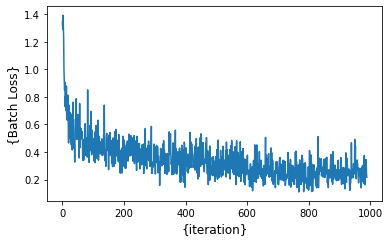

In [5]:
# learning parameters     
num_epochs = 50
learning_rate = 0.001

#device = torch.device ('cpu')
device = torch.device ('cuda') # Uncomment this to run on GPU    
    
#instance of the Conv Net
cnn = CNN()
cnn.to(device=device)

#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# the learning loop
losses = []
for epoch in range(1,num_epochs+1):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float()).to(device=device)
        labels = Variable(labels).to(device=device)
               
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    if(epoch == 1 or epoch % 10 == 0):    
        print ("Epoch : ", epoch, ", Training Loss: ",  loss.item())

# evaluate on the test set
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float()).to(device=device)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()
print("Test Accuracy of the model on the 10000 training test images: ", (100 * correct.item() / total),"%")

# plot
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=12)
#plt.tight_layout()
      
plt.plot(np.array(losses)[10:1000])
plt.xlabel(r'{iteration}',fontsize=12)
plt.ylabel(r'{Batch Loss}',fontsize=12)
plt.subplots_adjust(top=0.8)
plt.savefig("fashionloss.pdf",bbox_inches = "tight")
plt.show()